In [2]:
import numpy as np
np.random.seed(1001)

import os
import shutil
import soundfile as sf

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import librosa
import librosa.display
import re
from tqdm import tqdm
import time
from pathlib import Path

%matplotlib inline
matplotlib.style.use('ggplot')

from fastai import *
from fastai.vision import *

For this problem I decides to take the approach of generating images of spectogram for each audio file then feed the images as input into convolutional neural network to classify the audio. Another approach is to just used the input frequency of the data as input for simple neural network. The other approach is to use neural network to convert audio to text then classify the language based on the text. I've decided to use first approach as it can give quite good accuracy.

I'll be using fastai brilliant library for modelling and librosa to preprocess the audio.

In [ ]:
! pwd

In [ ]:
a = ! ls data/train -1t|head -n 5
a

In [ ]:
path = "data/train/es_m_f7d959494477e5e7e33d4666f15311c9.fragment8.noise10.flac"

In [ ]:
y, sr = librosa.load(path, sr=None)

In [ ]:
y.shape

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from itertools import islice
from pathlib import Path
from IPython.display import Audio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from scipy.signal import get_window

In [5]:
data = Path('data')
audio = data/'train'
audio

PosixPath('data/train')

Check the first 5 names of our data.

In [7]:
fnames = ! ls data/train -1t|head -n 5
fnames

['es_m_f7d959494477e5e7e33d4666f15311c9.fragment8.noise10.flac',
 'es_m_f7d959494477e5e7e33d4666f15311c9.fragment8.noise11.flac',
 'es_m_f7d959494477e5e7e33d4666f15311c9.fragment8.noise12.flac',
 'es_m_f7d959494477e5e7e33d4666f15311c9.fragment8.noise2.flac',
 'es_m_f7d959494477e5e7e33d4666f15311c9.fragment8.noise3.flac']

Clip a sample from the first sample

In [8]:
clip, sample_rate = librosa.load(audio/fnames[0], sr=None)
print('Sample Rate   {} Hz'.format(sample_rate))
print('Clip Length   {:3.2f} seconds'.format(len(clip)/sample_rate))

Sample Rate   22050 Hz
Clip Length   10.00 seconds


In [11]:
three_seconds = sample_rate * 3
clip = clip[:three_seconds]

Text(0, 0.5, 'Amplitude')

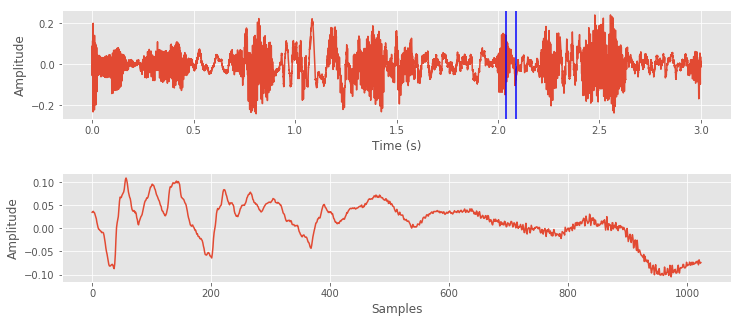

In [13]:
timesteps = np.arange(len(clip)) / sample_rate  # in seconds

fig, ax = plt.subplots(2, figsize=(12, 5))
fig.subplots_adjust(hspace=0.5)

# plot the entire clip 
ax[0].plot(timesteps, clip)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')



n_fft = 1024 # frame length 
start = 45000 # start at a part of the sound thats not silence.. 
x = clip[start:start+n_fft]

# mark location of frame in the entire signal
ax[0].axvline(start/sample_rate, c='b') 
ax[0].axvline((start+n_fft)/sample_rate, c='b')

# plot N samples 
ax[1].plot(x)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Amplitude')


In [15]:
Audio(clip, rate=sample_rate)

## Using Fast Fourier Transform

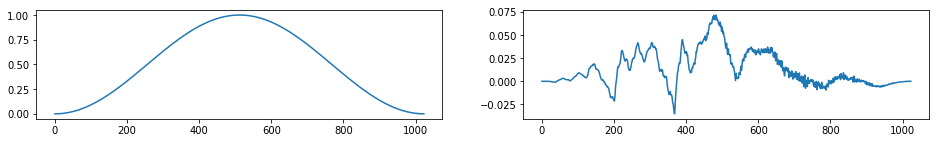

In [16]:
window = get_window('hann', n_fft)
wx = x * window

fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].plot(window)
ax[1].plot(wx);

In [17]:
# Compute (real) FFT on window
X = fft(x, n_fft)
X.shape, X.dtype

((1024,), dtype('complex64'))

((513,), dtype('float32'))

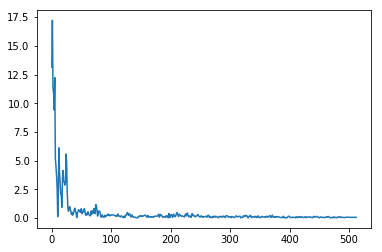

In [18]:
# We only use the first (n_fft/2)+1 numbers of the output, as the second half if redundant
X = X[:n_fft//2+1]

# Convert from rectangular to polar, usually only care about magnitude
X_magnitude, X_phase = librosa.magphase(X)

plt.plot(X_magnitude);

X_magnitude.shape, X_magnitude.dtype

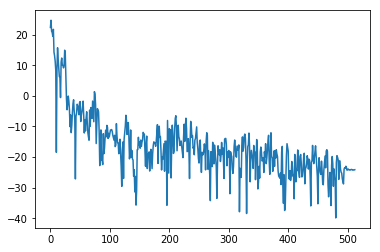

In [19]:
# we hear loudness in decibels (on a log scale of amplitude)
X_magnitude_db = librosa.amplitude_to_db(X_magnitude)

plt.plot(X_magnitude_db)

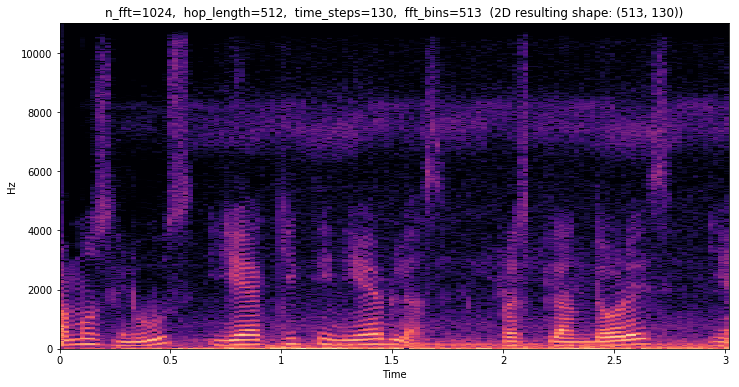

In [20]:
hop_length = 512
stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_magnitude_db, x_axis='time', y_axis='linear', 
                         sr=sample_rate, hop_length=hop_length)

title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(n_fft, hop_length, 
                       stft_magnitude_db.shape[1], 
                       stft_magnitude_db.shape[0], 
                       stft_magnitude_db.shape));

## Using melspectrograms

/opt/anaconda3/lib/python3.7/site-packages/librosa/filters.py:221: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


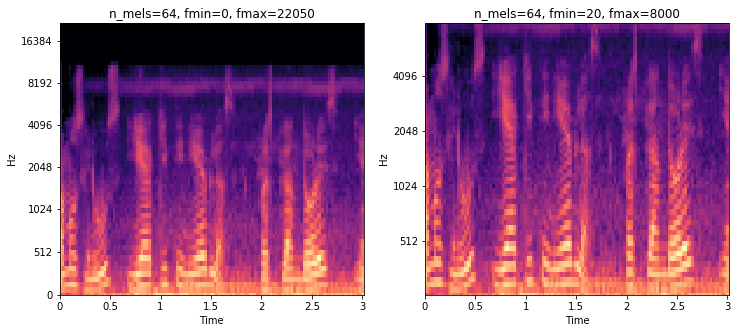

In [21]:
# number of mel frequency bands 
n_mels = 64

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

fmin = 0            
fmax = 22050 # sample_rate/2
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[0])
ax[0].set_title('n_mels=64, fmin=0, fmax=22050')

fmin = 20           
fmax = 8000
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0, 
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[1])
ax[1].set_title('n_mels=64, fmin=20, fmax=8000')

plt.show()

## Convert to mono

We'll only be using mono audio instead of stereo to compress the data.

In [48]:
DATA = Path('data')

TRAIN = DATA/'train'
TEST = DATA/'test'

MONO_TRAIN = DATA/'mono_train'
MONO_TEST = DATA/'mono_test'

In [45]:
import os
from functools import partial
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm
import soundfile as sf

def read_file(filename, path='', sample_rate=None, trim=False):
    ''' Reads in a flac file and returns it as an np.float32 array in the range [-1,1] '''
    filename = Path(path) / filename
    data, file_sr = librosa.load(filename)
    if data.dtype == np.int16:
        data = np.float32(data) / np.iinfo(np.int16).max
    elif data.dtype != np.float32:
        raise OSError('Encounted unexpected dtype: {}'.format(data.dtype))
    if sample_rate is not None and sample_rate != file_sr:
        if len(data) > 0:
            data = librosa.core.resample(data, file_sr, sample_rate, res_type='kaiser_fast')
        file_sr = sample_rate
    if trim and len(data) > 1:
        data = librosa.effects.trim(data, top_db=40)[0]
    return data, file_sr

def write_file(data, filename, path='', sample_rate=44100):
    ''' Writes a flac file to disk stored as int16 '''
    filename = Path(path) / filename
    if data.dtype == np.int16:
        int_data = data
    elif data.dtype == np.float32:
        int_data = np.int16(data * np.iinfo(np.int16).max)
    else:
        raise OSError('Input datatype {} not supported, use np.float32'.format(data.dtype))
    sf.write(filename, int_data, sample_rate)
    
def _to_mono(filename, dest_path):
    data, sr = read_file(filename)
    if len(data.shape) > 1:
        data = librosa.core.to_mono(data.T) # expects 2,n.. read_file returns n,2
    write_file(data, dest_path/filename.name, sample_rate=sr)


def convert_to_mono(src_path, dest_path, processes=None):
    src_path, dest_path = Path(src_path), Path(dest_path)
    os.makedirs(dest_path, exist_ok=True)
    filenames = list(src_path.iterdir())
    convert_fn = partial(_to_mono, dest_path=dest_path)
    with Pool(processes=processes) as pool:
        with tqdm(total=len(filenames), unit='files') as pbar:
            for _ in pool.imap_unordered(convert_fn, filenames):
                pbar.update()

In [46]:
convert_to_mono(TRAIN, MONO_TRAIN)

In [49]:
convert_to_mono(TEST, MONO_TEST)

## Generate Images

Let's generate the images of spectrograms.

In [101]:
DATA = Path('data')

# these folders must be in place
TRAIN_PATH = DATA/'mono_train'
TEST_PATH = DATA/'mono_test'

# these folders will be created
IMAGES = DATA/'mono_images'
TRAIN_IMAGE_PATH = IMAGES/'train'
TEST_IMAGE_PATH = IMAGES/'test'

In [102]:
train_fnames = [f.name for f in TRAIN_PATH.iterdir()]
test_fnames = [f.name for f in TEST_PATH.iterdir()]

In [79]:
Audio(str(TRAIN_PATH/fnames[0]))

In [80]:
x, sr = read_file(fnames[0], TRAIN_PATH)
x.shape, sr, x.dtype

((220500,), 22050, dtype('float32'))

In [103]:
def log_mel_spec_tfm(fname, src_path, dst_path):
    x, sample_rate = read_file(fname, src_path)
    
    n_fft = 1024
    hop_length = 256
    n_mels = 40
    fmin = 20
    fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
    dst_fname = dst_path / (".".join(fname.split('.')[:-1]) + '.png')
    plt.imsave(dst_fname, mel_spec_db)

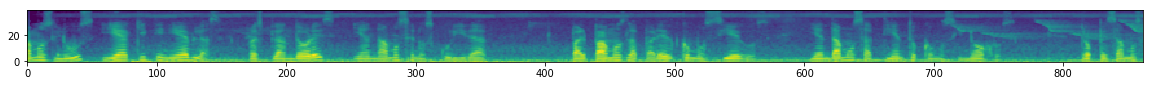

In [100]:
log_mel_spec_tfm(fnames[0], TRAIN_PATH, Path('.'))
img = plt.imread(".".join(fnames[0].split('.')[:-1]) + '.png')
plt.figure(figsize=(20,20))
plt.imshow(img, origin='lower')

In [104]:
def transform_path(src_path, dst_path, transform_fn, fnames=None, processes=None, delete=False, **kwargs):
    src_path, dst_path = Path(src_path), Path(dst_path)
    if dst_path.exists() and delete:
        shutil.rmtree(dst_path)
    os.makedirs(dst_path, exist_ok=True)
    
    _transformer = partial(transform_fn, src_path=src_path, dst_path=dst_path, **kwargs)
    if fnames is None:
        fnames = [f.name for f in src_path.iterdir()]
    with Pool(processes=processes) as pool:
        with tqdm(total=len(fnames), unit='files') as pbar:
            for _ in pool.imap_unordered(_transformer, fnames):
                pbar.update()

In [105]:
transform_path(TRAIN_PATH, TRAIN_IMAGE_PATH, log_mel_spec_tfm, 
               fnames=train_fnames, delete=True)

In [106]:
transform_path(TEST_PATH, TEST_IMAGE_PATH, log_mel_spec_tfm, 
               fnames=test_fnames, delete=True)

In [107]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
def get_filename(path):
    absolute_fname = path.as_posix()
    absolute_fname_parts = absolute_fname.split('/')
    fname = absolute_fname_parts[len(absolute_fname_parts) - 1]
    return fname

In [136]:
fnames = [get_filename(path) for path in fnames]

In [249]:
audio_train_path = Path("data/mono_images/train")
audio_train_paths = audio_train_path.ls()

# extract data from filenames

fnames = [get_filename(path) for path in audio_train_paths]
target = [f[:2] for f in fnames]
gender = [f[3] for f in fnames]
pattern = re.compile(r"speed[0-9]*|noise[0-9]*|pitch[0-9]*")
transformation = [pattern.findall(f) for f in fnames]
transformation = [f[0] if f else None for f in transformation]
pattern = re.compile(r"fragment[0-9]*")
fragment = [pattern.findall(f) for f in fnames]
fragment = [f[0] if f else None for f in fragment]

train_df = pd.DataFrame()
train_df["fnames"] = fnames
train_df["target"] = target
train_df["gender"] = gender
train_df["transformation"] = transformation
train_df["fragment"] = fragment

train_df.to_csv("train.csv")

In [6]:
audio_test_path = Path("data/mono_images/test")
audio_test_paths = audio_test_path.ls()

# extract data from filenames
fnames = [get_filename(path) for path in audio_test_paths]
target = [f[:2] for f in fnames]
gender = [f[3] for f in fnames]
pattern = re.compile(r"speed[0-9]*|noise[0-9]*|pitch[0-9]*")
transformation = [pattern.findall(f) for f in fnames]
transformation = [f[0] if f else None for f in transformation]
pattern = re.compile(r"fragment[0-9]*")
fragment = [pattern.findall(f) for f in fnames]
fragment = [f[0] if f else None for f in fragment]

test_df = pd.DataFrame()
test_df["fnames"] = fnames
test_df["target"] = target
test_df["gender"] = gender
test_df["transformation"] = transformation
test_df["fragment"] = fragment

audio_test_path = Path('data/test')
image_test_path = Path('data/test_spectrogram')

test_df.to_csv("test.csv")